In [ ]:
!pip install --global-option=--noopenmp dtaidistance

In [8]:
!pip install matplotlib --user

In [30]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from Parser import parse_frames
from scipy.signal import medfilt
from Functions import analyse_each_rep, find_extremas, filter_extremas, numpy_fillna, DTWDistance
from JointAngles import JointAngles
import numpy as np
import glob
import os
import pickle
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt


# Skip this part

In [22]:
# input_folder = "C:\\Users\\altaok\\Documents\\GitHub\\IndividualProject\\keypoints_for_all\\shoulder press"
input_folder = 'C:\\Users\\ak5u16\\Desktop\\IndividualProject\\keypoints_for_all\\shoulder_press'
folder_paths = glob.glob(os.path.join(input_folder, 'shoulder_press*'))
points_folder_name = os.path.basename(input_folder)

print(len(folder_paths))


def get_data_for_dataset(folder_paths, points_folder_name):
    angle_arrays = []
    for folder in folder_paths:
        video_name = os.path.basename(folder)
        label = 0 if '_correct' in folder else 1
        frame_poses = parse_frames(folder)
        joint_angles = JointAngles(points_folder_name, frame_poses)
        
        left_upArm_forearm_angles = np.array(joint_angles.left_upArm_forearm_angles)
        left_upArm_forearm_angles = np.nan_to_num(left_upArm_forearm_angles)
        left_upArm_forearm_angles_filtered = medfilt(medfilt(left_upArm_forearm_angles, 5), 5)
            
        right_upArm_forearm_angles = np.array(joint_angles.right_upArm_forearm_angles)
        right_upArm_forearm_angles = np.nan_to_num(right_upArm_forearm_angles)
        right_upArm_forearm_angles_filtered = medfilt(medfilt(right_upArm_forearm_angles, 5), 5)
            
        left_upArm_trunk_angles = np.array(joint_angles.left_upArm_trunk_angles)
        left_upArm_trunk_angles = np.nan_to_num(left_upArm_trunk_angles)
        left_upArm_trunk_angles_filtered = medfilt(medfilt(left_upArm_trunk_angles, 5), 5)
            
        right_upArm_trunk_angles = np.array(joint_angles.right_upArm_trunk_angles)
        right_upArm_trunk_angles = np.nan_to_num(right_upArm_trunk_angles)
        right_upArm_trunk_angles_filtered = medfilt(medfilt(right_upArm_trunk_angles, 5), 5)
            
        extremas1 = filter_extremas(left_upArm_trunk_angles_filtered, find_extremas(left_upArm_trunk_angles_filtered, maxima=False), maxima=False)
        extremas2 = filter_extremas(right_upArm_trunk_angles_filtered, find_extremas(right_upArm_trunk_angles_filtered, maxima=False), maxima=False)
            
        angle_arrays.append((label, extremas1, extremas2, [left_upArm_forearm_angles, right_upArm_forearm_angles, left_upArm_trunk_angles, right_upArm_trunk_angles]))


    return angle_arrays
                                             
                                    

def fill_dataframe(angle_arrays, exercise_folder_name):
    df_list = []
    
    print('Filling dataset with ' + str(exercise_folder_name) + ' data...')
   
    for tup in angle_arrays:
        label = tup[0]
        extremas1 = tup[1]
        extremas2 = tup[2]
        uf_angles1, uf_angles2, ut_angles1, ut_angles2 = tup[3]
        # Extract rep angles
        each_rep_angles = analyse_each_rep('shoulder press', 'dataset', extremas1=extremas1, uf_angles1=uf_angles1, ut_angles1=ut_angles1, extremas2=extremas2, uf_angles2=uf_angles2, ut_angles2=ut_angles2)
        #print(len(each_rep_angles))
        s1 = pd.Series(each_rep_angles, name='Angle_array')
        s2 = pd.Series([label for n in range(len(each_rep_angles))], name='Label')
        df = pd.concat([s1,s2], axis=1)
        df_list.append(df)

    return pd.concat(df_list).reset_index(drop=True)
        

56


In [23]:
angle_arrays = get_data_for_dataset(folder_paths, points_folder_name) 
df = fill_dataframe(angle_arrays, points_folder_name)
print(df.info())

Filling dataset with shoulder_press data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 2 columns):
Angle_array    1688 non-null object
Label          1688 non-null int64
dtypes: int64(1), object(1)
memory usage: 26.5+ KB
None


# Import dataset using pickle and perform clustering


In [2]:
df = pickle.load( open( "datasets/shoulder_press_df.pickle", "rb" ) )

#col_update = pd.DataFrame({'Angle_array': numpy_fillna(df['Angle_array'].values).tolist()})
#df.update(col_update)
df['Angle_array'] = df['Angle_array'].apply(lambda x: x / np.linalg.norm(x))



 

In [14]:
df.tail()

,Angle_array,Label
1683,"[0.12103272746981561, 0.1210505472681445, 0.12...",1
1684,"[0.12843393353494395, 0.12911819695472443, 0.1...",1
1685,"[0.12789677594087517, 0.13208306170781517, 0.1...",1
1686,"[0.12690270570458803, 0.1268985513474579, 0.12...",1
1687,"[0.13052651387525194, 0.13054011448106123, 0.1...",1


Cluster correct repetitions to create Ground Truth Model

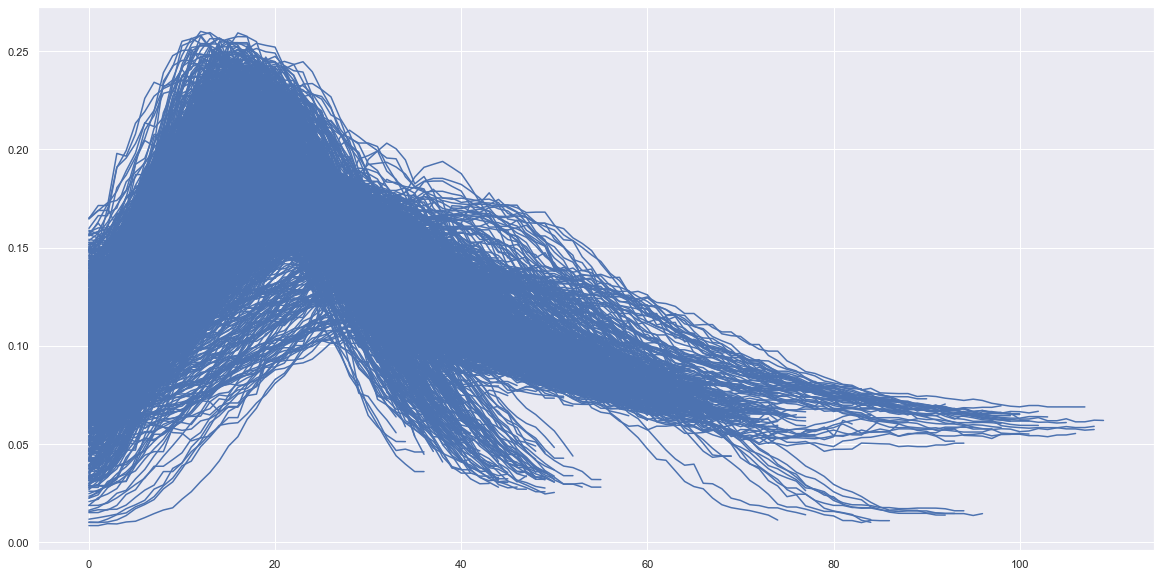

In [27]:
from dtaidistance import dtw, clustering
import seaborn as sns;sns.set()
#new_df = df[df['Label'] == 0]
series = df.Angle_array.values.tolist()

#model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
#cluster_idx = model1.fit(series)
# Augment Hierarchical object to keep track of the full tree
#model2 = clustering.HierarchicalTree(model1)
#cluster_idx = model2.fit(series)
# SciPy linkage clustering
#model = clustering.LinkageTree(dtw.distance_matrix_fast, {}, method='single')
#cluster_idx = model.fit(series)

timeseries = pd.DataFrame()
ax = None
plt.figure(figsize=(20, 10))
for ts in series:
    #print('Entered')
    df_ts = pd.DataFrame(ts)
    #print(df_ts.info())
    timeseries = timeseries.append(df_ts)
    ax = sns.lineplot(ax=ax,data=df_ts.values, legend=False)

plt.show()


In [40]:
from dtaidistance import dtw, clustering

model3 = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx = model3.fit(series)
print(cluster_idx)


The compiled dtaidistance C library is not available.
See the documentation for alternative installation options.


Exception: The compiled dtaidistance C library is not available.
See the documentation for alternative installation options.

In [41]:
dtw.try_import_c()

AttributeError: module 'dtaidistance.dtw' has no attribute 'try_import_c'

numpy.ndarray

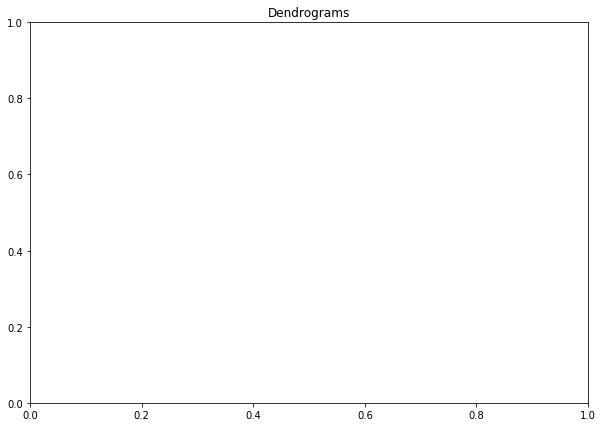

In [24]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

In [54]:
from sklearn.cluster import AgglomerativeClustering
series = df.Angle_array.values.tolist()
ds = dtw.distance_matrix_fast(series)
ds[ds == np.inf] = 0
print(ds)
cluster = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='single')  
cluster.fit_predict(ds)

[[0.         0.03380431 0.01991006 ... 0.3060875  0.29315313 0.3120431 ]
 [0.         0.         0.04711526 ... 0.27398871 0.26290212 0.27587267]
 [0.         0.         0.         ... 0.2855553  0.27332249 0.29256775]
 ...
 [0.         0.         0.         ... 0.         0.01787175 0.01445876]
 [0.         0.         0.         ... 0.         0.         0.0247402 ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [47]:
model.plot("myplot.png")

(None, None)

In [46]:
print(cluster_idx)

None


In [21]:
from sklearn.model_selection import train_test_split
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

y = df['Label']
x = df['Angle_array']
#x = numpy_fillna(x)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
X_train.shape

(1350,)

In [27]:
X_test.shape

(338,)

In [30]:
k_range = range(1, 26) #26
scores = {}
scores_list = []
for k in k_range:
    knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric="dtw", n_jobs=-1)
    #knn_clf = KNeighborsClassifier(k, n_jobs=-1)
    knn_clf.fit(numpy_fillna(X_train.values), y_train)
    #knn_clf.fit(X_train, y_train)
    predicted_labels = knn_clf.predict(numpy_fillna(X_test.values))
    acc = metrics.accuracy_score(y_test, predicted_labels)
    scores[k] = acc
    #print("Correct classification rate:", acc)
    #print('\n')
    #print(metrics.classification_report(y_test, predicted_labels))
    #print('F1 score: ' + str(metrics.f1_score(y_test, predicted_labels, average='macro')))


for key, value in scores.items():   
    if value == max(scores.values()):
        print('best value for k: ' + str(key) + ' - ' + str(value))
        break

best value for k: 3 - 0.9497041420118343


In [24]:
with open('datasets/shoulder_press_df.pickle', 'wb') as f:
    pickle.dump(df, f)